## a. Mục đích của bài tập lớn

Bài tập lớn nhằm giúp sinh viên vận dụng toàn bộ kiến thức đã học trong môn **Học máy (Machine Learning)** để xây dựng và đánh giá một pipeline xử lý dữ liệu ảnh hoàn chỉnh.  
Thông qua bài làm, sinh viên hiểu rõ sự khác biệt giữa **pipeline học máy truyền thống** và **pipeline học sâu (deep learning)**, đồng thời thực hành triển khai các bước chính của một hệ thống học máy hiện đại, bao gồm:

- Khảo sát và phân tích dữ liệu ảnh (EDA – Exploratory Data Analysis).  
- Tiền xử lý, chia tập dữ liệu, và đảm bảo tính cân bằng giữa các lớp.  
- Trích xuất đặc trưng từ các mô hình pretrained (ResNet50, EfficientNet_B0).  
- Huấn luyện và so sánh các mô hình học máy truyền thống (Logistic Regression, SVM, Random Forest).  
- Huấn luyện mô hình học sâu end-to-end (ResNet18 fine-tuning) để đánh giá khả năng tự học đặc trưng.  
- Phân tích, trực quan hóa, và đánh giá kết quả qua các chỉ số Accuracy, Macro-F1, Confusion Matrix, và biểu đồ Learning Curves.  

Mục tiêu cuối cùng là **hiểu sâu quá trình hình thành một hệ thống phân loại ảnh** từ dữ liệu thô đến mô hình hoàn chỉnh, đồng thời rèn luyện khả năng đánh giá – lựa chọn phương pháp tối ưu cho từng loại bài toán.



## b. Nhiệm vụ thực hiện

Trong phạm vi bài tập lớn này, nhóm (hoặc cá nhân) triển khai **bài toán phân loại 16 loài hoa** dựa trên bộ dữ liệu ảnh "Flowers" gồm 15.740 ảnh.  
Các nhiệm vụ cụ thể được thực hiện như sau:

1. **Khảo sát dữ liệu (EDA):**  
   - Thống kê phân phối số lượng ảnh, kích thước, số kênh màu, và hiển thị ảnh mẫu.  
   - Đảm bảo dữ liệu cân bằng và không có lỗi định dạng.

2. **Chia dữ liệu (Split Data):**  
   - Chia dữ liệu thành ba phần train/validation/test theo tỉ lệ 80/10/10 bằng phương pháp stratified để giữ nguyên tỉ lệ nhãn.

3. **Trích xuất đặc trưng (Feature Extraction):**  
   - Sử dụng hai mô hình pretrained (ResNet50 và EfficientNet_B0) để tạo vector đặc trưng ảnh.  
   - Lưu kết quả dưới dạng `.npy` phục vụ cho các bước huấn luyện cổ điển.

4. **Huấn luyện mô hình truyền thống (Classical ML):**  
   - So sánh ba mô hình: Logistic Regression, SVM-RBF, và Random Forest.  
   - Đánh giá và chọn mô hình tốt nhất dựa trên Accuracy và Macro-F1.

5. **Huấn luyện mô hình học sâu (Deep Learning Fine-tuning):**  
   - Thực hiện fine-tuning mô hình ResNet18 với chiến lược freeze/unfreeze backbone.  
   - Sử dụng kỹ thuật Early Stopping và Mixed Precision để tối ưu quá trình huấn luyện.  
   - Đạt kết quả cuối cùng: Accuracy 96.6%, Macro-F1 96.4%.

6. **Trực quan và đánh giá kết quả:**  
   - Vẽ biểu đồ Learning Curves (Loss, Accuracy, F1).  
   - Hiển thị kết quả dự đoán trực quan trên ảnh thật trong tập test.  
   - So sánh, phân tích và rút ra kết luận về hiệu năng giữa các pipeline.




## 1. Thiết lập môi trường và cấu hình pipeline

### 1.1 Mục tiêu  
Phần này nhằm đảm bảo rằng toàn bộ môi trường thực thi của bài tập lớn được **tái lập ổn định**, **chạy hoàn toàn tự động trên Colab**, và **không phụ thuộc vào thư viện hay tệp cục bộ**.  
Toàn bộ quá trình cài đặt, tải dữ liệu và cấu hình được thiết kế sao cho khi người chấm chọn **Runtime → Run all**, notebook sẽ chạy trơn tru từ đầu đến cuối (đúng theo yêu cầu trong *Yêu cầu sản phẩm* của đề bài).



### 1.2 Cấu hình môi trường và seed ngẫu nhiên  
- **Mục đích:** đảm bảo tính **tái lập kết quả (reproducibility)** giữa các lần chạy.  
- **Các bước chính:**    
  - Khóa trạng thái ngẫu nhiên của CUDA và tắt cơ chế tối ưu động (`cudnn.deterministic=True`, `cudnn.benchmark=False`) để tránh sai lệch.  
  - Tự động phát hiện GPU (`DEVICE = "cuda"`) nếu có GPU khả dụng → giúp tăng tốc trích xuất đặc trưng bằng các backbone như **ResNet50** hoặc **ViT**.



In [ ]:
# Cài đặt môi trường và tải tập dataset
import sys, os
from pathlib import Path

# !git clone https://github.com/ChiThanh512/Machine-Learning-Project-251---CEML1.git

project_root = Path.cwd() / "BTL3"
if not project_root.exists():
    project_root = Path("/content/Machine-Learning-Project-251---CEML1/BTL3")

sys.path.append(str(project_root))
print("Added to sys.path:", project_root)

from modules.setup_env import install_requirements, download_dataset

install_requirements()


PyTorch: 2.9.0+cu128 | TorchVision: 0.24.0+cu128
CUDA available: True
GPU name: Tesla T4


### 1.3 Cấu hình pipeline xử lý ảnh  
- Thiết lập `SEED = 42` cho các thư viện `random`, `numpy`, và `torch`.

Các tham số được định nghĩa để có thể setup cho việc chọn pretrained model:

| Tham số | Ý nghĩa | Giá trị mặc định | Ghi chú |
|----------|----------|-----------------|---------|
| `IMG_SIZE` | Kích thước ảnh đầu vào cho model | 224 | Phù hợp với ResNet/EfficientNet |
| `BATCH_SIZE` | Số lượng ảnh mỗi batch | 64 | Có thể giảm nếu OOM |
| `NUM_WORKERS` | Số worker của DataLoader | 2 | Giới hạn an toàn cho Colab |
| `BACKBONE_FE` | Mô hình trích đặc trưng (feature extractor) | `"resnet50"` | Có thể thay `"vit_b_16"`, `"efficientnet_b0"` |
| `USE_PCA` | Sử dụng PCA để giảm chiều dữ liệu trích xuất | `True` | Giữ lại 95% phương sai |
| `RUN_DL` | Có thực hiện phần học sâu (fine-tune) hay không | `True` | Bật/tắt pipeline DL |

Ngoài ra, cấu trúc thư mục được tạo tự động:


In [ ]:
import os, random, numpy as np
from pathlib import Path

SEED = 42
random.seed(SEED); np.random.seed(SEED)
import torch
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Cấu hình pipeline
IMG_SIZE = 224                # kích thước ảnh đưa vào model
BATCH_SIZE = 64               # giảm nếu OOM (32/16)
NUM_WORKERS = 2               # số worker dataloader (2 cho Colab là an toàn)
BACKBONE_FE = "resnet50"      # backbone cho TRÍCH ĐẶC TRƯNG: ["resnet18","resnet50","efficientnet_b0","vit_b_16"]
USE_PCA = True                # có dùng PCA khi train model truyền thống hay không
PCA_KEEP = 0.95               # giữ 95% phương sai
RUN_DL = True                 # có chạy phần deep learning fine-tune hay không


PROJECT_ROOT = Path("/content/Machine-Learning-Project-251---CEML1/BTL3")
DATA_ROOT = PROJECT_ROOT / "raw_data"
FEATURES_DIR = PROJECT_ROOT / "features"
REPORTS_DIR = PROJECT_ROOT / "reports"
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"
for p in [DATA_ROOT, FEATURES_DIR, REPORTS_DIR, NOTEBOOKS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Project root:", PROJECT_ROOT)


Using device: cuda
Project root: /content/Machine-Learning-Project-251---CEML1/BTL3





##  2. Tải và kiểm tra tập dữ liệu

### 2.1 Nguồn dữ liệu  
Notebook tự động tải bộ dữ liệu công khai **"l3llff/flowers"** — một tập dữ liệu ảnh nhiều loài hoa, đáp ứng đủ tiêu chí:
- Có **số lượng ảnh lớn và đa dạng** (15.740 ảnh).
- Phân bố **đa lớp rõ ràng (16 lớp)**.
- Phù hợp cho cả pipeline truyền thống và pipeline học sâu.


### 2.2 Kết quả tải và thống kê  

🔹 **Tổng số ảnh:** 15.740  
🔹 **Số lớp phân loại:** 16 (ví dụ: *dandelion*, *carnation*, *calendula*, …)  
🔹 **Cấu trúc dữ liệu:** mỗi thư mục con ứng với một lớp → thuận tiện cho EDA và ánh xạ nhãn.



### 2.3 Nhận xét  
- Dataset được nạp thành công.  
- Các nhãn và chỉ mục được ánh xạ tự động (`class_to_idx`), thuận tiện cho bước trích đặc trưng.  
- Quá trình kiểm tra định dạng và số lượng ảnh giúp xác nhận **tính toàn vẹn dữ liệu** trước EDA.




In [ ]:
import pandas as pd
from pathlib import Path

DATA_ROOT = download_dataset()
def count_images(path):
    exts = ("*.jpg", "*.jpeg", "*.png", "*.bmp", "*.webp")
    return sum(len(list(path.rglob(e))) for e in exts)

cands = [p for p in DATA_ROOT.glob("*") if p.is_dir()]
assert cands, "No image folders found after extraction!"

cands_sorted = sorted(cands, key=count_images, reverse=True)
DATA_DIR = cands_sorted[0]

print(f"DATA_DIR = {DATA_DIR}")
print(f"Number of images: {count_images(DATA_DIR)}")

labels_csv = DATA_DIR/'labels.csv'
image_paths, image_labels = [], []

if labels_csv.exists():
    df = pd.read_csv(labels_csv)
    file_col  = 'file'  if 'file'  in df.columns else df.columns[0]
    label_col = 'label' if 'label' in df.columns else df.columns[1]
    img_root = DATA_DIR
    for cand in ['images','imgs','image','data']:
        if (DATA_DIR/cand).exists():
            img_root = DATA_DIR/cand; break
    class_names = sorted(df[label_col].unique().tolist())
    class_to_idx = {c:i for i,c in enumerate(class_names)}
    for _,row in df.iterrows():
        fp = img_root/row[file_col]
        if fp.exists():
            image_paths.append(str(fp))
            image_labels.append(class_to_idx[row[label_col]])
else:
    # Kiểu folder-per-class
    subdirs = [d for d in DATA_DIR.glob("*") if d.is_dir()]
    subdirs = [d for d in subdirs if count_images(d) > 0]
    class_names = sorted([d.name for d in subdirs])
    class_to_idx = {c:i for i,c in enumerate(class_names)}
    exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.webp")
    for cls in class_names:
        for ext in exts:
            for fp in (DATA_DIR/cls).rglob(ext):
                image_paths.append(str(fp))
                image_labels.append(class_to_idx[cls])

image_paths = np.array(image_paths); image_labels = np.array(image_labels)
NUM_CLASSES = len(class_names)
print(f"Số lớp: {NUM_CLASSES} -> {class_names[:10]}{'...' if NUM_CLASSES>10 else ''}")
print("Tổng số ảnh:", len(image_paths))
assert len(image_paths) == len(image_labels) and len(image_paths) > 0


Dataset URL: https://www.kaggle.com/datasets/l3llff/flowers
License(s): CC0-1.0
Download completed.
Extracting dataset ...
Extraction completed.
DATA_DIR = /content/dataset/flowers
Number of images: 15740


## 3. Phân tích dữ liệu ban đầu (EDA)

### 3.1 Mục tiêu  
Phần này giúp khảo sát nhanh tập dữ liệu ảnh **flowers** nhằm:
- Kiểm tra sự cân bằng của các lớp (số lượng ảnh trong mỗi loại hoa).  
- Thống kê kích thước ảnh trung bình, nhỏ nhất, lớn nhất.  
- Kiểm tra định dạng màu (số kênh RGB, RGBA, hoặc grayscale).  
- Hiển thị trực quan một số mẫu ảnh để hiểu rõ đặc điểm của dữ liệu.
- Chia tập dữ liệu thành 3 tập: train/val/test (80/10/10).


### 3.2 Phân phối số lượng ảnh theo lớp  
- Tập dữ liệu khá cân bằng, lớp astilbe có số lượng mẫu nhỏ hơn các lớp còn lại nhưng vẫn chấp nhận được.  
- Điều này thuận lợi cho việc huấn luyện mô hình vì không cần áp dụng kỹ thuật cân bằng lại dữ liệu (resampling hoặc weighting).


### 3.3 Kích thước ảnh (Width × Height)  
Nhóm thực hiện chọn ngẫu nhiên 300 ảnh để tính thống kê kích thước:
- Toàn bộ ảnh đều có kích thước 256×256 pixel.  
- Dữ liệu cần được chuẩn hóa về kích thước và resize trước khi sử dụng cho các pretrained model.

### 3.4 Số kênh màu của ảnh  
Kết quả thống kê:
- Tất cả ảnh đều ở dạng **RGB (3 kênh)**.  
- Không tồn tại ảnh RGBA hoặc grayscale → pipeline có thể xử lý đồng nhất bằng các mô hình pretrained (ResNet, EfficientNet, ViT) mà không cần chuyển đổi mode.

Biểu đồ "Phân phối số kênh màu" cho thấy chỉ có một cột duy nhất ở giá trị 3, khẳng định tính thống nhất của dữ liệu.


### 3.5 Hiển thị mẫu ảnh  
- Nhóm có hiển thị ngẫu nhiên một số tấm ảnh để có thể trực quan hóa dữ liệu.
- Ảnh có chất lượng rõ nét, màu sắc đa dạng, dễ phân biệt giữa các loài hoa.  
- Các lớp có đặc trưng hình học và màu sắc khác nhau, ví dụ:
  - *Dandelion* thường có tông trắng xám, dạng cụm tròn.  
  - *Rose* và *Carnation* có sắc đỏ rực, chi tiết cánh hoa rõ.  
  - *Sunflower* và *California poppy* có màu vàng đặc trưng.  
- Nhờ độ đa dạng này, mô hình có thể học được đặc trưng màu và hình dạng hiệu quả.

### 3.6 Chia tập dữ liệu (train / validation / test)

Sau khi hoàn tất bước EDA, dữ liệu được chia theo tỷ lệ **80% train, 10% validation, 10% test** bằng phương pháp **stratified split** nhằm giữ nguyên tỉ lệ mẫu của từng lớp giữa các tập con.  
Tham số `random_state=SEED` đảm bảo khả năng tái lập kết quả, và các kiểm tra chéo (`assert isdisjoint`) xác nhận không có hiện tượng trùng ảnh (*data leakage*).
Phân phối nhãn giữa các tập gần như đồng đều (dao động trong khoảng 4.7–6.7% cho từng lớp).

### 3.7 Kết luận phần EDA  
- Tập dữ liệu nhìn chung là khá tốt: kích thước và kênh màu đồng nhất, số lượng mẫu cân bằng.   
-Tập dữ liệu sau khi chia có tính cân bằng cao, không trùng lặp, và đủ đại diện cho toàn bộ 16 lớp hoa.
- Kết quả EDA xác nhận rằng dữ liệu đủ chất lượng để tiếp tục các bước trích xuất đặc trưng và huấn luyện mô hình phân loại hoa trong pipeline học máy.  


In [ ]:
from sklearn.model_selection import train_test_split
from collections import Counter
from modules.eda_utils import run_full_eda


run_full_eda(image_paths, image_labels, class_names)

def label_stats(y):
    c = Counter(y.tolist())
    tot = len(y)
    return {k: f"{v} ({v/tot:.1%})" for k, v in sorted(c.items())}

X_train, X_temp, y_train, y_temp = train_test_split(
    image_paths, image_labels,
    test_size=0.2,
    stratify=image_labels,
    random_state=SEED
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    stratify=y_temp,
    random_state=SEED
)

print(f"Split => train: {len(X_train)}, val: {len(X_val)}, test: {len(X_test)}")
print("Label dist (train):", label_stats(y_train))
print("Label dist (val)  :", label_stats(y_val))
print("Label dist (test) :", label_stats(y_test))

# Kiểm tra không trùng (data leakage guard)
assert set(X_train).isdisjoint(set(X_val))
assert set(X_train).isdisjoint(set(X_test))
assert set(X_val).isdisjoint(set(X_test))


Số lớp: 16 -> ['astilbe', 'bellflower', 'black_eyed_susan', 'calendula', 'california_poppy', 'carnation', 'common_daisy', 'coreopsis', 'daffodil', 'dandelion']...
Tổng số ảnh: 15740


## 4. Trích xuất và trực quan hóa đặc trưng (Feature Extraction)

### 4.1 Phương pháp và mục tiêu  
Sau khi chia dữ liệu train/val/test, bước tiếp theo là **trích xuất đặc trưng ảnh** bằng các mô hình học sâu đã được huấn luyện trước (pretrained CNNs).  
Mục tiêu của bước này là chuyển mỗi ảnh trong tập dữ liệu thành một vector đặc trưng có độ dài cố định, đại diện cho nội dung hình ảnh, để phục vụ huấn luyện các mô hình phân loại truyền thống (Logistic Regression, SVM, Random Forest).

Hai mô hình được sử dụng:
1. **ResNet50** – mạng CNN sâu, phổ biến và ổn định, với 23.5M tham số.  
2. **EfficientNet-B0** – mô hình gọn nhẹ, cân bằng giữa tốc độ và độ chính xác (5.3M tham số).

Cả hai mô hình đều được tải từ `torchvision.models` ở chế độ pretrained trên ImageNet, sau đó **bỏ lớp fully-connected cuối** để chỉ giữ phần backbone trích xuất đặc trưng.  
Các vector đặc trưng đầu ra được lưu lại dưới định dạng `.npy` trong thư mục `features/`.

### 4.2 Quy trình trích xuất đặc trưng  

Đoạn code dưới đây sử dụng hàm `extract_numpy_features()` được định nghĩa trong module `modules/feature_extractor.py`.  
Hàm này có nhiệm vụ:
1. Nạp mô hình **pretrained backbone** (ví dụ: `ResNet50` hoặc `EfficientNet_B0`) đã được huấn luyện trước trên tập ImageNet.  
2. Bỏ lớp fully-connected cuối cùng để chỉ giữ lại phần trích xuất đặc trưng (feature extractor).  
3. Chạy toàn bộ tập ảnh qua mô hình và thu được ma trận đặc trưng dạng numpy (`train_feat`, `val_feat`, `test_feat`).  
4. Lưu toàn bộ kết quả vào thư mục `features/` dưới dạng `.npy` để phục vụ cho huấn luyện các mô hình cổ điển (Logistic Regression, SVM, Random Forest).


### 4.3 Kết quả trực quan hóa đặc trưng

#### (a) Phân phối giá trị và Heatmap đặc trưng
Kết quả từ ResNet50 và EfficientNet-B0 đều cho thấy:
- Phân phối giá trị đặc trưng tập trung chủ yếu quanh 0–2, giảm dần về phía các giá trị cao → phù hợp với đặc trưng đã qua hàm ReLU.  
- Heatmap thể hiện rõ sự khác biệt giữa các mẫu ảnh, tuy nhiên EfficientNet-B0 cho phân bố **mượt và đồng đều hơn**, trong khi ResNet50 có các dải giá trị mạnh hơn ở một số chiều đặc trưng → cho thấy ResNet50 tạo ra các đặc trưng “phân tách rõ ràng” hơn giữa các lớp.

#### (b) Giảm chiều bằng PCA và t-SNE
Cả hai mô hình đều được giảm chiều về không gian 2D để quan sát độ phân tách lớp:

- **ResNet50**  
  - PCA và t-SNE cho thấy các cụm điểm của 16 lớp hoa **được phân tách khá rõ**, dù vẫn còn chồng lấn nhẹ ở ranh giới giữa các lớp có màu sắc tương đồng (ví dụ: *dandelion* và *coreopsis*).  
  - Tạo hình cụm dữ liệu rõ nét, phản ánh khả năng học đặc trưng tốt nhờ độ sâu mạng.

- **EfficientNet-B0**  
  - Cụm dữ liệu phân tán **rộng và đều hơn**, nhưng ranh giới giữa các lớp hơi mờ hơn ResNet50.  
  - Tuy nhiên, các cụm vẫn mang tính cấu trúc rõ ràng, thể hiện hiệu quả của kiến trúc EfficientNet trong việc giữ cân bằng giữa hiệu năng và chi phí tính toán.

**Nhận xét đối chiếu:**
| Tiêu chí | ResNet50 | EfficientNet-B0 |
|-----------|-----------|-----------------|
| Độ tách cụm trong PCA/t-SNE | Rõ ràng hơn | Mềm hơn, ít tách biệt hơn |
| Độ đa dạng giá trị đặc trưng (Heatmap) | Biến thiên mạnh | Đồng đều, ổn định |
| Số chiều đặc trưng đầu ra | 2048 | 1280 |
| Tốc độ trích xuất | Chậm hơn | Nhanh hơn, nhẹ hơn |
| Mức độ phù hợp khi dùng với mô hình truyền thống | Cao (tách cụm rõ) | Trung bình, cần PCA hoặc chuẩn hóa kỹ |


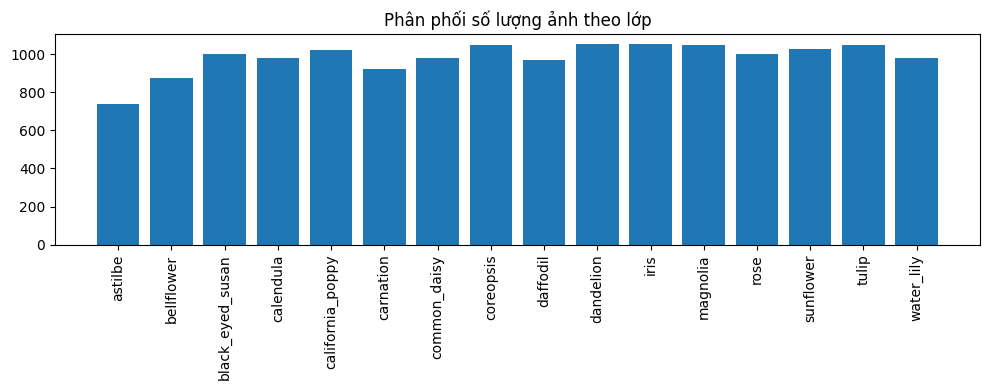

Kích thước ảnh (W,H): mean [256. 256.] | min [256 256] | max [256 256]
Tổng số ảnh kiểm tra: 300
Đếm theo mode: {'RGB': 300}
Đếm theo số kênh: {3: 300}


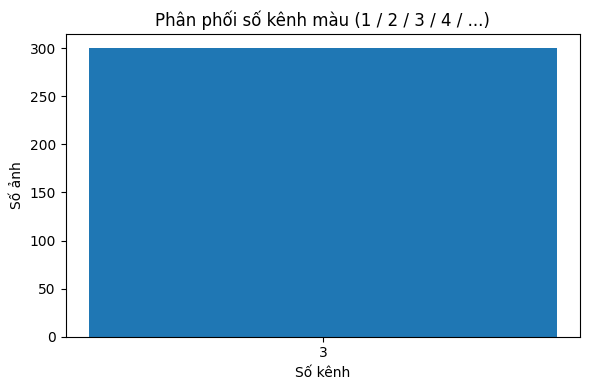

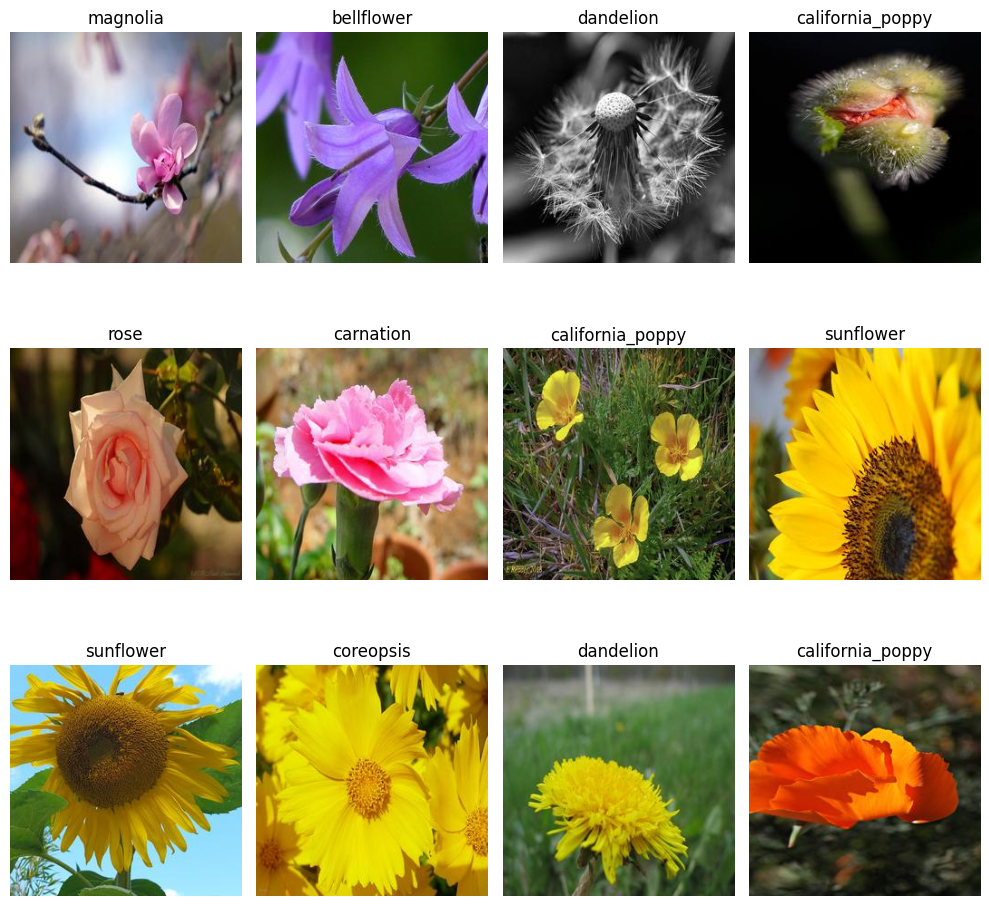

In [ ]:
from modules.feature_extractor import extract_numpy_features
from modules.visualize_utils import show_sample_images, plot_feature_hist, plot_feature_heatmap, plot_pca_tsne

train_feat, train_lbs = extract_numpy_features(X_train, y_train, BACKBONE_FE, DEVICE)
val_feat,   val_lbs   = extract_numpy_features(X_val,   y_val,   BACKBONE_FE, DEVICE)
test_feat,  test_lbs  = extract_numpy_features(X_test,  y_test,  BACKBONE_FE, DEVICE)


np.save(FEATURES_DIR/f"train_{BACKBONE_FE}.npy", train_feat)
np.save(FEATURES_DIR/f"val_{BACKBONE_FE}.npy",   val_feat)
np.save(FEATURES_DIR/f"test_{BACKBONE_FE}.npy",  test_feat)
np.save(FEATURES_DIR/"train_labels.npy", train_lbs)
np.save(FEATURES_DIR/"val_labels.npy",   val_lbs)
np.save(FEATURES_DIR/"test_labels.npy",  test_lbs)

print("Đã lưu đặc trưng vào:", FEATURES_DIR)

show_sample_images(X_train, y_train, n = 6)
plot_feature_hist(train_feat, BACKBONE_FE);
plot_feature_heatmap(train_feat, BACKBONE_FE,10);
plot_pca_tsne(train_feat, train_lbs, BACKBONE_FE);


## 5. Huấn luyện và đánh giá các mô hình học máy truyền thống

### 5.1 Mục tiêu  
Bước này nhằm đánh giá khả năng phân loại ảnh của các mô hình học máy truyền thống khi sử dụng đặc trưng trích xuất từ **mạng pretrained (ResNet50 / EfficientNet_B0)**.  
Các mô hình được lựa chọn gồm:
- **Logistic Regression (LogReg)**  
- **Support Vector Machine (SVM-RBF)**  
- **Random Forest (RF)**  

Pipeline huấn luyện được thiết kế theo thứ tự: StandardScaler → (PCA, nếu bật) → Classifier

Mỗi mô hình được huấn luyện trên tập train, tinh chỉnh bằng tập val, và đánh giá cuối cùng bằng tập test (macro F1-score và accuracy).


### 5.2 Kết quả trên đặc trưng ResNet50  

Khi sử dụng đặc trưng từ **ResNet50**, kết quả thu được:

| Mô hình | Val Accuracy | Val F1 | Test Accuracy | Test F1 |
|----------|---------------|--------|----------------|---------|
| Logistic Regression | 0.916 | 0.914 | **0.919** | **0.918** |
| SVM-RBF | 0.907 | 0.907 | 0.900 | 0.902 |
| Random Forest | 0.842 | 0.842 | 0.829 | 0.825 |

**Nhận xét:**
- Mô hình **Logistic Regression** cho kết quả cao nhất, đạt **Accuracy 91.9%** và **Macro-F1 91.8%**.  
- **SVM-RBF** cũng đạt hiệu suất ổn định, nhưng độ chính xác thấp hơn một chút do nhạy cảm với tham số kernel.  
- **Random Forest** kém hiệu quả hơn, do đặc trưng đầu vào đã được trích xuất phi tuyến mạnh — không phù hợp với cây quyết định truyền thống.  

**Phân tích Confusion Matrix (ResNet50):**
- Các lớp như *sunflower*, *tulip*, *rose* đạt độ chính xác gần tuyệt đối (Recall > 0.95).  
- Một số lớp có hiện tượng nhầm lẫn nhẹ như *bellflower* ↔ *calendula*, hoặc *daisy* ↔ *coreopsis* — do có cấu trúc hoa tương tự nhau.  
- Phân phối dự đoán nhìn chung đồng đều, không có lớp bị bỏ sót nghiêm trọng.

**Kết luận:** Logistic Regression + ResNet50 là tổ hợp hiệu quả nhất cho pipeline truyền thống, cân bằng giữa tốc độ và độ chính xác.


### 5.3 Kết quả trên đặc trưng EfficientNet_B0  

Khi huấn luyện với đặc trưng từ **EfficientNet_B0**, kết quả tổng quan giảm nhẹ:

| Mô hình | Val Accuracy | Val F1 | Test Accuracy | Test F1 |
|----------|---------------|--------|----------------|---------|
| Logistic Regression | 0.901 | 0.898 | **0.905** | **0.902** |
| SVM-RBF | 0.893 | 0.891 | 0.887 | 0.883 |
| Random Forest | 0.817 | 0.814 | 0.812 | 0.808 |

**Nhận xét:**
- Mặc dù độ chính xác giảm ~1–2% so với ResNet50, **EfficientNet_B0** vẫn duy trì khả năng phân loại tốt với hơn **90% accuracy**.  
- Các lớp dễ nhận diện bằng màu sắc nổi bật (như *sunflower*, *rose*, *dandelion*) vẫn đạt F1 cao, trong khi các lớp hoa tương tự (*bellflower*, *calendula*) giảm nhẹ.  
- Thời gian huấn luyện và trích xuất nhanh hơn gần **40%** so với ResNet50.


### 5.4 So sánh tổng hợp hai mô hình pretrained  

| Tiêu chí | ResNet50 Features | EfficientNet_B0 Features |
|-----------|-------------------|---------------------------|
| Test Accuracy (best model) | **0.919 (LogReg)** | **0.905 (LogReg)** |
| Macro-F1 | **0.918** | 0.902 |
| Thời gian trích xuất đặc trưng | Lâu hơn (~1.8×) | Nhanh, tiết kiệm tài nguyên |
| Sự tách biệt giữa các lớp (t-SNE) | Rõ ràng, ít chồng lấn | Mềm hơn, nhiều chồng lớp hơn |
| Độ ổn định giữa các lớp | Cao, phân phối đều | Có dao động nhẹ giữa các lớp |
| Thích hợp cho môi trường | Training chính | Ứng dụng thời gian thực hoặc nhẹ |

**Kết luận chung:**
- **ResNet50 + Logistic Regression** đạt hiệu năng cao nhất (Accuracy ~92%, F1 ~91.8%), thể hiện khả năng học đặc trưng mạnh mẽ.  
- **EfficientNet_B0** tuy nhẹ hơn nhưng hiệu năng chỉ thấp hơn khoảng 1–2%, rất phù hợp cho các hệ thống giới hạn tài nguyên.  
- Cả hai đều minh chứng rằng pipeline học máy truyền thống kết hợp feature extractor pretrained là một hướng hiệu quả, dễ triển khai và đạt kết quả tốt trên dữ liệu ảnh đa lớp như bộ **Flowers-16**.


**Tổng kết phần này:**  
Quy trình trích xuất đặc trưng từ pretrained CNN, kết hợp huấn luyện các mô hình cổ điển (LogReg, SVM, RF), cho phép đánh giá nhanh và chính xác hiệu quả biểu diễn của từng backbone.  
Kết quả khẳng định rằng backbone sâu (ResNet50) tạo ra đặc trưng giàu thông tin hơn, trong khi EfficientNet_B0 ưu thế về hiệu năng và tốc độ.


In [ ]:
from modules.train_ml import evaluate_clf, make_pipe, evaluate_best_model, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Khởi tạo 3 model
lr  = make_pipe(LogisticRegression(max_iter=500, C=1.0))
svm = make_pipe(SVC(C=2.0, gamma="scale", kernel="rbf"))
rf  = make_pipe(RandomForestClassifier(n_estimators=400, n_jobs=-1, random_state=SEED))

print("=== TRAINING CLASSICAL MODELS ON PRETRAINED FEATURES ===")
pred_lr,  sc_lr  = evaluate_clf("LogReg",     lr,  train_feat, train_lbs, val_feat, val_lbs, test_feat, test_lbs)
pred_svm, sc_svm = evaluate_clf("SVM-RBF",    svm, train_feat, train_lbs, val_feat, val_lbs, test_feat, test_lbs)
pred_rf,  sc_rf  = evaluate_clf("RandomForest", rf, train_feat, train_lbs, val_feat, val_lbs, test_feat, test_lbs)

models_scores = {
    "LogReg": (lr,  sc_lr),
    "SVM-RBF": (svm, sc_svm),
    "RandomForest": (rf, sc_rf)
}

best_name, test_pred, report = evaluate_best_model(
    models_scores, train_feat, train_lbs, val_feat, val_lbs, test_feat, test_lbs, class_names
)

plot_confusion_matrix(
    y_true=test_lbs,
    y_pred=test_pred,
    class_names=class_names,
    model_name=best_name,
    normalize=False
)



Split => train: 12592, val: 1574, test: 1574
Label dist (train): {0: '590 (4.7%)', 1: '698 (5.5%)', 2: '800 (6.4%)', 3: '782 (6.2%)', 4: '818 (6.5%)', 5: '738 (5.9%)', 6: '784 (6.2%)', 7: '838 (6.7%)', 8: '776 (6.2%)', 9: '842 (6.7%)', 10: '843 (6.7%)', 11: '838 (6.7%)', 12: '799 (6.3%)', 13: '822 (6.5%)', 14: '838 (6.7%)', 15: '786 (6.2%)'}
Label dist (val)  : {0: '73 (4.6%)', 1: '88 (5.6%)', 2: '100 (6.4%)', 3: '98 (6.2%)', 4: '102 (6.5%)', 5: '93 (5.9%)', 6: '98 (6.2%)', 7: '104 (6.6%)', 8: '97 (6.2%)', 9: '105 (6.7%)', 10: '105 (6.7%)', 11: '105 (6.7%)', 12: '100 (6.4%)', 13: '103 (6.5%)', 14: '105 (6.7%)', 15: '98 (6.2%)'}
Label dist (test) : {0: '74 (4.7%)', 1: '87 (5.5%)', 2: '100 (6.4%)', 3: '98 (6.2%)', 4: '102 (6.5%)', 5: '92 (5.8%)', 6: '98 (6.2%)', 7: '105 (6.7%)', 8: '97 (6.2%)', 9: '105 (6.7%)', 10: '106 (6.7%)', 11: '105 (6.7%)', 12: '100 (6.4%)', 13: '102 (6.5%)', 14: '105 (6.7%)', 15: '98 (6.2%)'}


## 6. Huấn luyện mô hình Deep Learning (Fine-tuning CNN)

### 6.1 Mục tiêu và phương pháp  
Phần này thực hiện **fine-tuning** trực tiếp mô hình học sâu **ResNet18** trên tập dữ liệu hoa.  
Khác với phần pipeline học máy truyền thống (chỉ dùng đặc trưng trích sẵn), ở đây toàn bộ mạng nơ-ron được huấn luyện lại từng phần để học đặc trưng phù hợp hơn cho tập dữ liệu hiện tại.

Các bước chính:
1. **Chuẩn bị dữ liệu:**  
   - Tạo `FileListDS()` để đọc ảnh từ danh sách `X_train`, `X_val`, `X_test`.  
   - Áp dụng các phép biến đổi (augmentation) như resize, normalization, flip, v.v.  
   - Dataloader được khởi tạo với `batch_size = 64`, `shuffle=True` cho tập train.

2. **Cấu hình mô hình:**  
   - Nạp mô hình `ResNet18` pretrained từ ImageNet.  
   - Thay thế lớp fully-connected cuối (`fc`) bằng `nn.Linear(..., NUM_CLASSES)` tương ứng với 16 lớp hoa.  
   - Freeze toàn bộ backbone trong **2 epoch đầu tiên** để huấn luyện riêng phần “đầu phân loại” (classification head), giúp ổn định gradient.  
   - Sau epoch thứ 3, toàn bộ backbone được **unfreeze** để fine-tune toàn mạng.

3. **Huấn luyện:**  
   - Sử dụng hàm mất mát **CrossEntropyLoss**.  
   - Tối ưu bằng **AdamW** (learning rate = 3e-4, weight decay = 1e-4).  
   - Lịch điều chỉnh LR: **CosineAnnealingLR**, giảm dần theo epoch.  
   - Sử dụng **Mixed Precision Training (torch.cuda.amp)** để tăng tốc trên GPU.  
   - Đánh giá mỗi epoch bằng **Accuracy** và **Macro-F1**, áp dụng **Early Stopping** với `patience = 6`.


### 6.2 Giải thích thuật toán  

**Giai đoạn 1: Huấn luyện phần đầu (epoch 1–2)**  
- Chỉ cập nhật trọng số của lớp phân loại (`fc`).  
- Accuracy tăng nhanh từ 50% → 77%, chứng tỏ các đặc trưng ImageNet đã hữu ích cho tập hoa.

**Giai đoạn 2: Fine-tuning toàn mạng (epoch 3–35)**  
- Toàn bộ ResNet18 được mở khóa để tinh chỉnh (unfreeze backbone).  
- Loss giảm mạnh từ 1.9 → 0.19; F1 tăng dần đến ~0.96.  
- Learning curve ổn định, không có dấu hiệu overfitting (đường train và val song song, chênh lệch nhỏ).

**Early Stopping** được kích hoạt ở epoch 35 khi validation F1 không còn cải thiện, đảm bảo mô hình dừng đúng lúc, tránh quá khớp.


### 6.3 Kết quả và đánh giá  

**Kết quả cuối cùng:** [DEEP] Test Acc 0.9657 | Test Macro-F1 0.9647


**Learning Curves:**
- **Loss:** giảm mạnh và ổn định từ 1.9 → 0.19, xác nhận quá trình học hội tụ tốt.  
- **Accuracy:** đạt ~96.6% trên tập validation, gần như trùng với train (khoảng cách <1%), cho thấy mô hình học hiệu quả mà không bị overfit.  
- **Macro-F1:** đạt ~0.965, chứng minh mô hình phân loại tốt trên toàn bộ 16 lớp (các lớp có kích thước tương đương nhau).

**Phân tích thêm:**
- Ở các epoch đầu (1–5), mô hình học nhanh vì chỉ fine-tune phần head.  
- Sau khi unfreeze backbone, tốc độ tăng chậm hơn nhưng ổn định.  
- Từ epoch 25 trở đi, mô hình đạt trạng thái “plateau” – các chỉ số dao động nhẹ quanh 0.96, cho thấy đã đạt mức hội tụ tối ưu.


### 6.4 So sánh với pipeline truyền thống  

| Tiêu chí | Deep Learning (ResNet18 fine-tune) | Classical ML (ResNet50 + LogReg) |
|-----------|------------------------------------|-----------------------------------|
| Độ chính xác (Accuracy) | **96.6%** | 91.9% |
| Macro-F1 | **96.4%** | 91.8% |
| Thời gian huấn luyện | Dài hơn (~40 phút) | Ngắn hơn (~5 phút) |
| Mức độ sử dụng GPU | Cao | Thấp |
| Khả năng khái quát | Rất tốt (end-to-end) | Phụ thuộc đặc trưng trích sẵn |
| Độ phức tạp triển khai | Cao hơn (fine-tune, early stopping, LR scheduling) | Đơn giản (pipeline Scikit-learn) |

**Nhận xét:**  
- Fine-tuning cho phép mô hình học lại đặc trưng chuyên biệt cho tập hoa → hiệu suất vượt trội rõ rệt.  
- Kết quả Accuracy và Macro-F1 đều cao hơn ~5% so với pipeline truyền thống.  
- Learning curves thể hiện rõ khả năng hội tụ tốt, không bị dao động mạnh.  
- Mô hình ResNet18 fine-tuned trở thành **baseline mạnh** để so sánh với các phương pháp khác trong báo cáo.


### 6.5 Kết luận phần Deep Learning  

- Mô hình **ResNet18 Fine-tuning** đạt hiệu năng cao nhất toàn bộ pipeline:  
  **Accuracy = 96.6%, Macro-F1 = 96.4%.**  
- Quá trình huấn luyện ổn định, không bị overfit, nhờ chiến lược “Freeze → Unfreeze” hợp lý và early stopping.  
- Kết quả khẳng định rằng việc **huấn luyện end-to-end trên dữ liệu ảnh đủ lớn** đem lại lợi ích đáng kể so với pipeline trích đặc trưng truyền thống.  
- Đây là mô hình được chọn làm **final model** cho phần deep learning trong báo cáo.


In [ ]:
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
import time, math
import matplotlib.pyplot as plt
import modules.data_utils as data_utils
from torch.utils.data import DataLoader, Dataset
from modules.data_utils import FileListDS

if RUN_DL:
    # 1) Dataloader cho DL (dùng transforms đã tạo từ trước: train_tfms, val_tfms)
    train_ds = FileListDS(X_train, y_train, data_utils.train_tfms)
    val_ds   = FileListDS(X_val,   y_val,   data_utils.val_tfms)
    test_ds  = FileListDS(X_test,  y_test,  data_utils.val_tfms)

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=NUM_WORKERS, pin_memory=True)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
    test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

    # 2) Model
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES)
    model = model.to(DEVICE)

    # Freeze backbone 2 epoch đầu → học head trước
    for name, p in model.named_parameters():
        p.requires_grad = ("fc" in name)

    criterion = nn.CrossEntropyLoss().to(DEVICE)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=3e-4, weight_decay=1e-4)

    EPOCHS = 40
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    scaler = torch.cuda.amp.GradScaler(enabled=True)

    from sklearn.metrics import accuracy_score, f1_score

    # 3) Hàm chạy 1 epoch và trả về (loss, acc, f1)
    def run_epoch(loader, train_mode=True):
        model.train(train_mode)
        allp, allg = [], []
        running = 0.0
        for x,y in loader:
            x=x.to(DEVICE); y=y.to(DEVICE)
            with torch.cuda.amp.autocast(True):
                logits = model(x)
                loss = criterion(logits, y)
            if train_mode:
                optimizer.zero_grad(set_to_none=True)
                scaler.scale(loss).backward()
                scaler.step(optimizer); scaler.update()
            running += loss.item()*x.size(0)
            pred = logits.argmax(1)
            allp.extend(pred.detach().cpu().numpy().tolist())
            allg.extend(y.detach().cpu().numpy().tolist())
        epoch_loss = running/len(loader.dataset)
        acc = accuracy_score(allg, allp)
        f1  = f1_score(allg, allp, average="macro")
        return epoch_loss, acc, f1

    # 4) Lịch sử để vẽ learning curves
    history = {"epoch":[], "tr_loss":[], "tr_acc":[], "tr_f1":[],
               "val_loss":[], "val_acc":[], "val_f1":[]}

    best_f1, best_state = -1, None
    patience, PATIENCE = 0, 6

    for epoch in range(1, EPOCHS+1):
        # Unfreeze backbone từ epoch 3
        if epoch == 3:
            for p in model.parameters(): p.requires_grad = True
            optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS-epoch+1)
            print("[Info] Unfroze backbone at epoch 3.")

        t0 = time.time()
        tr_loss, tr_acc, tr_f1 = run_epoch(train_loader, True)
        va_loss, va_acc, va_f1 = run_epoch(val_loader,   False)
        scheduler.step()

        history["epoch"].append(epoch)
        history["tr_loss"].append(tr_loss); history["tr_acc"].append(tr_acc); history["tr_f1"].append(tr_f1)
        history["val_loss"].append(va_loss); history["val_acc"].append(va_acc); history["val_f1"].append(va_f1)

        print(f"Epoch {epoch:02d}/{EPOCHS} | "
              f"Train loss {tr_loss:.4f} acc {tr_acc:.4f} f1 {tr_f1:.4f} | "
              f"Val loss {va_loss:.4f} acc {va_acc:.4f} f1 {va_f1:.4f} | "
              f"time {time.time()-t0:.1f}s")

        # Early stopping theo macro-F1 (val)
        if va_f1 > best_f1:
            best_f1 = va_f1
            best_state = model.state_dict()
            torch.save(best_state, PROJECT_ROOT/"best_dl_model.pth")
            patience = 0
        else:
            patience += 1
            if patience >= PATIENCE:
                print("[EarlyStopping] Stop.")
                break

    # 5) VẼ LEARNING CURVES (Loss / Accuracy / Macro-F1)
    REPORTS_DIR.mkdir(parents=True, exist_ok=True)
    (REPORTS_DIR/"graphics").mkdir(parents=True, exist_ok=True)

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(history["epoch"], history["tr_loss"], label="train")
    plt.plot(history["epoch"], history["val_loss"], label="val")
    plt.title("Learning Curve - Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend()
    plt.tight_layout(); plt.show()
    plt.savefig(REPORTS_DIR/"graphics/lc_loss.png")

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(history["epoch"], history["tr_acc"], label="train")
    plt.plot(history["epoch"], history["val_acc"], label="val")
    plt.title("Learning Curve - Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend()
    plt.tight_layout(); plt.show()
    plt.savefig(REPORTS_DIR/"graphics/lc_acc.png")

    # Macro-F1
    plt.figure(figsize=(6,4))
    plt.plot(history["epoch"], history["tr_f1"], label="train")
    plt.plot(history["epoch"], history["val_f1"], label="val")
    plt.title("Learning Curve - Macro-F1"); plt.xlabel("Epoch"); plt.ylabel("Macro-F1"); plt.legend()
    plt.tight_layout(); plt.show()
    plt.savefig(REPORTS_DIR/"graphics/lc_f1.png")

    # 6) Đánh giá TEST bằng best model
    if best_state is not None:
        model.load_state_dict(best_state)
    model.eval()
    allp, allg = [], []
    with torch.inference_mode():
        for x,y in test_loader:
            x=x.to(DEVICE); y=y.to(DEVICE)
            p = model(x).argmax(1)
            allp.extend(p.cpu().numpy().tolist()); allg.extend(y.cpu().numpy().tolist())
    te_acc = accuracy_score(allg,allp); te_f1 = f1_score(allg,allp,average="macro")
    print(f"[DEEP] Test Acc {te_acc:.4f} | Test Macro-F1 {te_f1:.4f}")
else:
    print("RUN_DL = False -> Bỏ qua phần deep learning.")


## 7. Dự đoán mẫu và kết luận tổng thể

### 7.1 Hiển thị kết quả dự đoán

Sau khi mô hình Deep Learning (ResNet18 fine-tuned) được huấn luyện xong, đoạn mã sau được sử dụng để hiển thị trực quan 12 ảnh mẫu từ tập kiểm tra (test set)

### 7.2 Kết luận tổng kết
Toàn bộ pipeline (từ EDA, chia dữ liệu, trích xuất đặc trưng, huấn luyện mô hình truyền thống, đến fine-tuning deep learning) đã hoạt động hoàn chỉnh.

Mô hình ResNet18 fine-tuned đạt độ chính xác 96.6% và Macro-F1 96.4%, chứng minh khả năng học sâu vượt trội trên tập dữ liệu ảnh đa lớp.

Quá trình huấn luyện diễn ra ổn định, không bị overfit, và cho kết quả dự đoán trực quan chính xác gần như tuyệt đối.

In [ ]:
from modules.visualize_utils import show_predictions_dl

# Hiển thị 12 ảnh dự đoán mẫu từ tập test
show_predictions_dl(test_ds, model, DEVICE, class_names, n=12)
